In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

import seaborn as sns 



In [2]:
df_stationary= pd.read_csv("output_preprocess/df_stationary_nonexog.csv", index_col=0)

In [3]:
df_stationary.index= pd.to_datetime(df_stationary.index)

Identify ruptures in data 

In [4]:
import ruptures as rpt
series= df_stationary['PCE'].dropna().values

for pen in [0.5, 1, 2, 3, 5]:
    bps = rpt.Pelt(model="rbf").fit(series).predict(pen=pen)
    print(f"pen={pen}: {bps}")
    break_dates = df_stationary.index[bps[:-1]]  # skip the last endpoint
    print("Break dates:", break_dates)



pen=0.5: [10, 25, 35, 45, 60, 65, 70, 75, 90, 100, 105, 110, 135, 140, 150, 155, 165, 170, 180, 195, 205, 220, 227]
Break dates: DatetimeIndex(['2007-03-31', '2008-06-30', '2009-04-30', '2010-02-28',
               '2011-05-31', '2011-10-31', '2012-03-31', '2012-08-31',
               '2013-11-30', '2014-09-30', '2015-02-28', '2015-07-31',
               '2017-08-31', '2018-01-31', '2018-11-30', '2019-04-30',
               '2020-02-29', '2020-07-31', '2021-05-31', '2022-08-31',
               '2023-06-30', '2024-09-30'],
              dtype='datetime64[ns]', freq=None)
pen=1: [25, 35, 45, 65, 75, 165, 170, 180, 195, 205, 227]
Break dates: DatetimeIndex(['2008-06-30', '2009-04-30', '2010-02-28', '2011-10-31',
               '2012-08-31', '2020-02-29', '2020-07-31', '2021-05-31',
               '2022-08-31', '2023-06-30'],
              dtype='datetime64[ns]', freq=None)
pen=2: [25, 35, 165, 180, 227]
Break dates: DatetimeIndex(['2008-06-30', '2009-04-30', '2020-02-29', '2021-05-31'], d

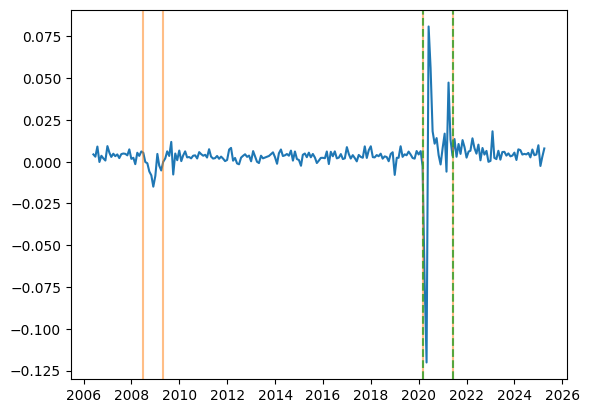

In [5]:
# (['2008-06-30', '2009-04-30', '2020-02-29', '2021-05-31'])
series = df_stationary['PCE'].dropna()
bps_pen2 = [ '2008-06-30', '2009-04-30', '2020-02-29', '2021-05-31' ]
bps_pen3 = [ '2020-02-29', '2021-05-31' ]
plt.plot(figsize=(12,6))
plt.plot(series.index, series.values, label='PCE stationary')
for d in bps_pen2:
    plt.axvline(pd.to_datetime(d),color='C1', alpha= 0.5)

for d in bps_pen3: 
    plt.axvline(pd.to_datetime(d), color='C2', linestyle='--', alpha=0.8)

In [ ]:
# PCE,COMPI,2,0.02067393034525758
# PCE,CRUDE,2,0.00022660772852255517
# PCE,FEDFUNDS,6,1.5547325072786658e-09
# PCE,GDPDEF,6,0.04389164459794585
# PCE,INDPRO,1,5.80306838185245e-10
# PCE,LABOR,1,2.150199727568233e-05
# PCE,M2,1,0.00011229495745744364
# PCE,UNRATE,1,4.3920257150697847e-23
# PCE,WAGE_AVG,1,2.719219006000888e-16

In [6]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [7]:
def make_break_dummies(df, break_dates):
    X= df.copy()
    for idx, dates in enumerate(break_dates):
        X[f'break_{idx+1}']= (X.index>= pd.to_datetime(dates)).astype(int)
    return X

preds=['UNRATE', 'M2', 'FEDFUNDS']#took because they are proven to be relevant indicators of PCE 
y= df_stationary['PCE'].dropna()
X_base= df_stationary[preds].loc[y.index]

X2 = make_break_dummies(X_base, bps_pen2)
X4 = make_break_dummies(X_base, bps_pen3)

# confirm both have same columns in train/test split
print("X2 columns:", X2.columns)
print("X4 columns:", X4.columns)

# train/test split for OOS check
split = int(0.9*len(y))
y_train, y_test = y.iloc[:split], y.iloc[split:]
X2_train, X2_test = X2.iloc[:split], X2.iloc[split:]
X4_train, X4_test = X4.iloc[:split], X4.iloc[split:]
print("X2 test columns:", X2_test.columns)
print("X4 test columns:", X4_test.columns)


X2 columns: Index(['UNRATE', 'M2', 'FEDFUNDS', 'break_1', 'break_2', 'break_3', 'break_4'], dtype='object')
X4 columns: Index(['UNRATE', 'M2', 'FEDFUNDS', 'break_1', 'break_2'], dtype='object')
X2 test columns: Index(['UNRATE', 'M2', 'FEDFUNDS', 'break_1', 'break_2', 'break_3', 'break_4'], dtype='object')
X4 test columns: Index(['UNRATE', 'M2', 'FEDFUNDS', 'break_1', 'break_2'], dtype='object')


In [8]:

def fit_and_score(Xtr, ytr, Xte, yte):
    # Add constant once in both, ensure same column order
    Xtrc = sm.add_constant(Xtr, has_constant='add').fillna(0)
    Xtec = sm.add_constant(Xte, has_constant='add').fillna(0)
    Xtec = Xtec.reindex(columns=Xtrc.columns, fill_value=0)

    model = sm.OLS(ytr, Xtrc).fit()
    preds = model.predict(Xtec)
    rmse = np.sqrt(mean_squared_error(yte, preds))
    return model, model.aic, model.bic, rmse


m2, aic2, bic2, rmse2 = fit_and_score(X2_train, y_train, X2_test, y_test)
m4, aic4, bic4, rmse4 = fit_and_score(X4_train, y_train, X4_test, y_test)

print("pen=2 -> AIC:", aic2, "BIC:", bic2, "OOS RMSE:", rmse2)
print("pen=4 -> AIC:", aic4, "BIC:", bic4, "OOS RMSE:", rmse4)

#scores for both are same 

pen=2 -> AIC: -1407.1740257424262 BIC: -1390.5834257732051 OOS RMSE: 0.00517409632043671
pen=4 -> AIC: -1407.1740257424262 BIC: -1390.5834257732051 OOS RMSE: 0.005174096320436713


Testing without Covid period

In [9]:
# testing without covid distortion
covid_start = pd.to_datetime('2020-02-29')
covid_end = pd.to_datetime('2021-05-31')
# [ '2020-02-29', '2021-05-31' ]

# remove COVID period
mask = (df_stationary.index < covid_start) | (df_stationary.index > covid_end)
df_no_covid = df_stationary.loc[mask].copy()

y_nc = df_no_covid['PCE']
X_nc = df_no_covid[preds]
m_full, aic_full, bic_full, rmse_full = fit_and_score(X_base, y, X_base, y)
m_no_covid, aic_nc, bic_nc, rmse_nc = fit_and_score(X_nc, y_nc, X_nc, y_nc)

print("FULL sample:", aic_full, bic_full, rmse_full)
print("NO COVID :", aic_nc, bic_nc, rmse_nc)



FULL sample: -1583.2811139271516 -1569.581313857226 0.007270261537256654
NO COVID : -1780.101636719838 -1766.6942041859338 0.0034959637048281138


In [65]:
df_no_covid = df_stationary.loc[mask].copy()

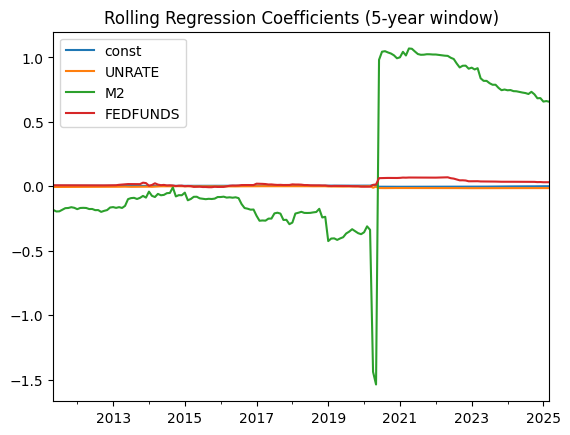

In [10]:
window = 60  # assuming monthly data, ~5 years
rolling_betas = []

for i in range(window, len(y)):
    y_sub = y.iloc[i-window:i]
    X_sub = X_base.iloc[i-window:i]
    model = sm.OLS(y_sub, sm.add_constant(X_sub)).fit()
    rolling_betas.append(model.params)

rolling_betas = pd.DataFrame(rolling_betas, index=y.index[window:])
rolling_betas.plot(title="Rolling Regression Coefficients (5-year window)")
plt.show()

breakpoints for nocovid data 

In [11]:
series_noncovid= df_no_covid['PCE'].dropna().values

for pen in [0.5, 1, 2, 3, 5]:
    bps = rpt.Pelt(model="rbf").fit(series_noncovid).predict(pen=pen)
    print(f"pen={pen}: {bps}")
    break_dates = df_no_covid.index[bps[:-1]]  # skip the last endpoint
    print("Break dates:", break_dates)

pen=0.5: [10, 25, 35, 45, 60, 65, 70, 75, 90, 100, 105, 110, 135, 140, 150, 155, 165, 170, 180, 190, 205, 211]
Break dates: DatetimeIndex(['2007-03-31', '2008-06-30', '2009-04-30', '2010-02-28',
               '2011-05-31', '2011-10-31', '2012-03-31', '2012-08-31',
               '2013-11-30', '2014-09-30', '2015-02-28', '2015-07-31',
               '2017-08-31', '2018-01-31', '2018-11-30', '2019-04-30',
               '2021-06-30', '2021-11-30', '2022-09-30', '2023-07-31',
               '2024-10-31'],
              dtype='datetime64[ns]', freq=None)
pen=1: [25, 35, 45, 65, 75, 165, 180, 190, 211]
Break dates: DatetimeIndex(['2008-06-30', '2009-04-30', '2010-02-28', '2011-10-31',
               '2012-08-31', '2021-06-30', '2022-09-30', '2023-07-31'],
              dtype='datetime64[ns]', freq=None)
pen=2: [25, 35, 150, 211]
Break dates: DatetimeIndex(['2008-06-30', '2009-04-30', '2018-11-30'], dtype='datetime64[ns]', freq=None)
pen=3: [211]
Break dates: DatetimeIndex([], dtype='dateti

Main factors for PCE

In [30]:
# cols=['WAGE_AVG', 'UNRATE', 'CPI','PCE', 'CSENT']
cols= ['UNRATE','CPI', 'PCE']


In [37]:
df_var= df_no_covid[cols].copy()

In [42]:
# univariate granger tests
from statsmodels.tsa.stattools import grangercausalitytests
variables = ['UNRATE', 'PCE', 'CPI', 'FEDFUNDS', 'M2', 'WAGE_AVG', 'INDPRO',
       'GDPDEF', 'CSENT', 'CRUDE', 'COMPI', 'LABOR']
max_lag = 12

results_list = []

for target in variables:
    for predictor in variables:
        if target == predictor:
            continue
        try:
            test_data = df_no_covid[[target, predictor]].dropna()
            test_result = grangercausalitytests(test_data, maxlag=max_lag, verbose=False)

            for lag in range(1, max_lag + 1):
                p_val = test_result[lag][0]['ssr_ftest'][1]
                results_list.append({
                    'target': target,
                    'predictor': predictor,
                    'lag': lag,
                    'p_value': p_val
                })

        except Exception as e:
            print(f"Error testing {predictor} => {target}: {e}")

# Convert to DataFrame
granger_df = pd.DataFrame(results_list)

# Filter to keep only significant results (e.g., p < 0.05)
significant = granger_df[granger_df['p_value'] < 0.05]

# Optional: get best (lowest p) lag per pair
best_per_pair = significant.groupby(['target', 'predictor']).apply(lambda g: g.loc[g['p_value'].idxmin()]).reset_index(drop=True)

# Save if needed
import os 
directory_name="granger_outputs"
os.makedirs(name=directory_name,exist_ok=True)
granger_df.to_csv(f'{directory_name}/granger_all_results.csv', index=False)
best_per_pair.to_csv(f'{directory_name}/granger_significant_summary.csv', index=False)

/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since fu

In [57]:
# PCE,COMPI,12,4.4220892180843066e-05
# PCE,CPI,1,0.0008390010535906243
# PCE,CRUDE,7,1.5945623450084626e-05
# PCE,FEDFUNDS,5,0.004481585198916759
# PCE,GDPDEF,4,0.040466415709547614
# PCE,INDPRO,3,0.00475127477117123
# PCE,UNRATE,1,0.0018874933008874103
# We pick COMPI , CRUDE, FedFunds for longterm VAR 
#we pick UNRATE and CPI for short term VAR
cols_longterm=['CRUDE','FEDFUNDS','PCE']
cols_shorterm=['CPI','UNRATE', 'PCE']
cols_compi=['COMPI','PCE']

df_no_covid_short=df_no_covid.copy()[cols_shorterm]
df_no_covid_long= df_no_covid.copy()[cols_longterm]


In [58]:
df_no_covid_compi= df_no_covid.copy()[cols_compi]

In [59]:
df_no_covid_short.head()
type(df_no_covid_short.index)
df_no_covid_short.shape

(211, 3)

In [60]:
def recommend_maxlags(n_obs, n_vars, max_ratio=0.25):
    max_params = n_obs * max_ratio
    max_p = int(max_params / (n_vars ** 2))
    return max(1, max_p)  # at least 1 lag
n_obs = len(df_no_covid_short)
n_vars = df_no_covid_short.shape[1]

maxlags = recommend_maxlags(n_obs,n_vars )
print(f"Recommended maxlags based on data: {maxlags}")

from statsmodels.tsa.api import VAR

model = VAR(df_no_covid_short)
lag_selection = model.select_order(maxlags=maxlags)
print(lag_selection.summary())

best_lag = lag_selection.selected_orders['aic']  # or 'bic'
print("Best lag by AIC:", best_lag)

Recommended maxlags based on data: 5
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -15.73      -15.68   1.479e-07      -15.71
1      -16.22     -16.03*   9.005e-08     -16.14*
2      -16.25      -15.91   8.770e-08      -16.11
3     -16.25*      -15.77  8.761e-08*      -16.05
4      -16.21      -15.58   9.142e-08      -15.95
5      -16.20      -15.42   9.262e-08      -15.88
-------------------------------------------------
Best lag by AIC: 3


/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [61]:
n_obs = len(df_no_covid_long)
n_vars = df_no_covid_long.shape[1]

maxlags = recommend_maxlags(n_obs,n_vars )
print(f"Recommended maxlags based on data: {maxlags}")

model = VAR(df_no_covid_long)
lag_selection = model.select_order(maxlags=maxlags)
print(lag_selection.summary())

best_lag = lag_selection.selected_orders['aic']  # or 'bic'
print("Best lag by AIC:", best_lag)

Recommended maxlags based on data: 5
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -17.29      -17.24   3.103e-08      -17.27
1      -20.61     -20.42*   1.119e-09     -20.53*
2      -20.66      -20.32   1.067e-09      -20.52
3      -20.69      -20.20   1.036e-09      -20.49
4      -20.68      -20.05   1.048e-09      -20.42
5     -20.78*      -20.00  9.495e-10*      -20.46
-------------------------------------------------
Best lag by AIC: 5


/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [62]:
n_obs = len(df_no_covid_compi)
n_vars = df_no_covid_compi.shape[1]

maxlags = recommend_maxlags(n_obs,n_vars )
print(f"Recommended maxlags based on data: {maxlags}")

model = VAR(df_no_covid_compi)
lag_selection = model.select_order(maxlags=maxlags)
print(lag_selection.summary())

best_lag = lag_selection.selected_orders['aic']  # or 'bic'
print("Best lag by AIC:", best_lag)

Recommended maxlags based on data: 13
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -20.27      -20.24   1.574e-09      -20.26
1       -20.52     -20.42*   1.225e-09     -20.48*
2       -20.53      -20.37   1.208e-09      -20.47
3       -20.56      -20.33   1.176e-09      -20.47
4       -20.56      -20.26   1.182e-09      -20.44
5      -20.57*      -20.20  1.169e-09*      -20.42
6       -20.56      -20.13   1.181e-09      -20.38
7       -20.55      -20.06   1.185e-09      -20.35
8       -20.52      -19.96   1.223e-09      -20.29
9       -20.53      -19.90   1.217e-09      -20.27
10      -20.56      -19.86   1.182e-09      -20.28
11      -20.55      -19.79   1.188e-09      -20.24
12      -20.56      -19.73   1.180e-09      -20.22
13      -20.56      -19.66   1.181e-09      -20.20
--------------------------------------------------
Best lag by AIC: 5


/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Reference code 

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# === 1. Define variable groups and max lags ===
short_vars = ['PCE', 'CPI', 'UNRATE']
long_vars = ['PCE', 'CRUDE', 'FEDFUNDS']
compi_vars = ['PCE', 'COMPI']

maxlags_dict = {
    'short': 4,
    'long': 12,
    'compi': 6
}

# === 2. Train-test split ===
train_size = int(len(df) * 0.9)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# === Helper function to fit VAR and return fitted model ===
def fit_var(endog_df, maxlags):
    model = VAR(endog_df)
    results = model.fit(maxlags=maxlags)
    return results

# === 3. Fit VARs on training data ===
var_short = fit_var(train_df[short_vars].dropna(), maxlags_dict['short'])
var_long = fit_var(train_df[long_vars].dropna(), maxlags_dict['long'])
var_compi = fit_var(train_df[compi_vars].dropna(), maxlags_dict['compi'])

# === 4. Generate rolling forecasts inside training data ===
def rolling_forecasts(var_model, data, maxlags):
    """
    Generate one-step ahead rolling forecasts inside training data.
    var_model: fitted VAR results (from full train)
    data: DataFrame of the VAR variables (train data)
    maxlags: number of lags used in VAR model
    Returns a Series of forecasted values for the first variable (PCE)
    """
    forecasts = []
    start = maxlags
    for i in range(start, len(data)):
        train_slice = data.iloc[:i]
        model = VAR(train_slice)
        fitted = model.fit(maxlags=maxlags)
        input_for_forecast = train_slice.values[-maxlags:]
        forecast = fitted.forecast(input_for_forecast, steps=1)[0][0]  # PCE forecast is first var
        forecasts.append(forecast)
    # pad beginning with NaNs for alignment
    forecasts = [np.nan]*maxlags + forecasts
    return pd.Series(forecasts, index=data.index)

train_short_forecasts = rolling_forecasts(var_short, train_df[short_vars], maxlags_dict['short'])
train_long_forecasts = rolling_forecasts(var_long, train_df[long_vars], maxlags_dict['long'])
train_compi_forecasts = rolling_forecasts(var_compi, train_df[compi_vars], maxlags_dict['compi'])

# === 5. Prepare training dataset for linear regression ===
train_preds = pd.DataFrame({
    'short': train_short_forecasts,
    'long': train_long_forecasts,
    'compi': train_compi_forecasts,
    'actual': train_df['PCE']
}).dropna()

X_train = train_preds[['short', 'long', 'compi']]
y_train = train_preds['actual']

# === 6. Train linear regression (with Ridge regularization) ===
lr = Ridge(alpha=1.0)  # alpha can be tuned
lr.fit(X_train, y_train)
print("Linear regression weights:", lr.coef_)

# === 7. Forecast on test set with each VAR ===
def var_forecast(var_results, train_data, test_data, maxlags):
    """
    Forecast PCE on test_data using var_results model.
    Use last maxlags points of train_data to initialize forecasting.
    """
    input_for_forecast = train_data.values[-maxlags:]
    steps = len(test_data)
    forecast_vals = var_results.forecast(input_for_forecast, steps=steps)
    # PCE is first variable
    return pd.Series(forecast_vals[:, 0], index=test_data.index)

test_short_forecast = var_forecast(var_short, train_df[short_vars], test_df[short_vars], maxlags_dict['short'])
test_long_forecast = var_forecast(var_long, train_df[long_vars], test_df[long_vars], maxlags_dict['long'])
test_compi_forecast = var_forecast(var_compi, train_df[compi_vars], test_df[compi_vars], maxlags_dict['compi'])

# === 8. Combine test VAR forecasts using trained linear regression ===
test_preds = pd.DataFrame({
    'short': test_short_forecast,
    'long': test_long_forecast,
    'compi': test_compi_forecast,
    'actual': test_df['PCE']
}).dropna()

X_test = test_preds[['short', 'long', 'compi']]
y_test = test_preds['actual']

final_forecast = lr.predict(X_test)

# === 9. Evaluate performance ===
rmse = np.sqrt(mean_squared_error(y_test, final_forecast))
print(f"Final combined model RMSE on test set: {rmse:.4f}")

# Optional: compare with individual VAR RMSEs
rmse_short = np.sqrt(mean_squared_error(y_test, test_preds['short']))
rmse_long = np.sqrt(mean_squared_error(y_test, test_preds['long']))
rmse_compi = np.sqrt(mean_squared_error(y_test, test_preds['compi']))

print(f"Individual VAR RMSEs on test set: short={rmse_short:.4f}, long={rmse_long:.4f}, compi={rmse_compi:.4f}")


My code

In [66]:
# add exog factors 
bps=pd.to_datetime(['2008-06-30', '2009-04-30', '2018-11-30'])
for i,date in enumerate(bps):
    df_no_covid[f'D{i}']= df_no_covid.index<bps[i]

exo_vars=df_no_covid[['D0', 'D1','D2']]



In [68]:
df_no_covid.head()

,UNRATE,PCE,CPI,FEDFUNDS,M2,WAGE_AVG,INDPRO,GDPDEF,CSENT,CRUDE,COMPI,LABOR,D0,D1,D2
2006-05-31,-0.1,0.004364,0.6,0.15,0.001013,-0.000993,0.000251,0.000,-8.3,4.260482,0.009088,0.0,True,True,True
2006-06-30,0.0,0.003007,0.5,0.05,0.005591,0.004955,0.003362,0.000,5.8,4.261988,0.001808,0.1,True,True,True
2006-07-31,0.1,0.009052,1.1,0.25,0.006082,0.002962,-0.000653,0.586,-0.2,4.309604,0.004205,-0.1,True,True,True
2006-08-31,0.0,-0.000171,0.9,0.01,0.004544,0.001477,0.004331,0.000,-2.7,4.291049,0.006573,0.1,True,True,True
2006-09-30,-0.2,0.003547,-1.0,0.00,0.003934,0.003929,-0.001813,0.000,3.4,4.155722,-0.015002,-0.1,True,True,True


In [70]:
#Save the 
maxlags_dict={
    'short':3,
    'long':5,
    'compi':5,
}
split=int(len(df_no_covid)*0.9)
train_df= df_no_covid.iloc[:split]
test_df= df_no_covid.iloc[split:]
# === Helper function to fit VAR and return fitted model ===
def fit_var(endog_df, maxlags, exog_df):
    model = VAR(endog_df, exog=exog_df)
    results = model.fit(maxlags=maxlags)
    return results

# === 3. Fit VARs on training data ===
# var_short = fit_var(train_df[cols_shorterm].dropna(), maxlags_dict['short'])
# var_long = fit_var(train_df[cols_longterm].dropna(), maxlags_dict['long'])
# var_compi = fit_var(train_df[cols_compi].dropna(), maxlags_dict['compi'])
var_short = fit_var(train_df[cols_shorterm].dropna(), maxlags_dict['short'], train_df[['D0','D1','D2']].dropna())
var_long = fit_var(train_df[cols_longterm].dropna(), maxlags_dict['long'], train_df[['D0','D1','D2']].dropna())
var_compi = fit_var(train_df[cols_compi].dropna(), maxlags_dict['compi'], train_df[['D0','D1','D2']].dropna())

#plot results on test and forecasted data for each of these models 



/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [79]:
def rolling_forecasts(data, exog_data, maxlags):
    """
    Generate one-step ahead rolling forecasts inside training data for the first variable (PCE).
    Parameters:
        data: DataFrame of VAR variables for training (including PCE)
        exog_data: DataFrame of exogenous variables aligned with data
        maxlags: number of lags to use
    
    Returns:
        pandas Series with forecasted values for PCE
    """
    forecasts = []
    start = maxlags + 2
    
    for i in range(start, len(data)):
        train_slice = data.iloc[:i]
        exog_slice = exog_data.iloc[:i]
        
        if len(train_slice) <= maxlags:
            forecasts.append(np.nan)
            continue
        
        model = VAR(train_slice, exog=exog_slice)
        fitted = model.fit(maxlags=maxlags)
        
        input_endog = train_slice.values[-maxlags:]
        input_exog = exog_slice.values[-1].reshape(1, -1)
        
        forecast = fitted.forecast(y=input_endog, steps=1, exog_future=input_exog)
        
        # Assuming PCE is first column in data
        forecasts.append(forecast[0][-1])
    
    forecasts = [np.nan] * start + forecasts
    return pd.Series(forecasts, index=data.index)


In [81]:
from sklearn.linear_model import Ridge

In [82]:

train_short_forecasts = rolling_forecasts( train_df[cols_shorterm],exo_vars, maxlags_dict['short'])
train_long_forecasts = rolling_forecasts(train_df[cols_longterm],exo_vars, maxlags_dict['long'])
train_compi_forecasts = rolling_forecasts(train_df[cols_compi],exo_vars, maxlags_dict['compi'])

# === 5. Prepare training dataset for linear regression ===
train_preds = pd.DataFrame({
    'short': train_short_forecasts,
    'long': train_long_forecasts,
    'compi': train_compi_forecasts,
    'actual': train_df['PCE']
}).dropna()

X_train = train_preds[['short', 'long', 'compi']]
y_train = train_preds['actual']

# === 6. Train linear regression (with Ridge regularization) ===
lr = Ridge(alpha=1.0)  # alpha can be tuned
lr.fit(X_train, y_train)
print("Linear regression weights:", lr.coef_)



/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/minic

Linear regression weights: [0.00046146 0.00039215 0.00055925]


/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/minic

In [84]:

# === 7. Forecast on test set with each VAR ===
def var_forecast(var_results, train_data, test_data, maxlags, exog_test):
    """
    Forecast PCE on test_data using var_results model.
    Use last maxlags points of train_data to initialize forecasting.
    exog_test: DataFrame of exogenous variables aligned with test_data (must have same length)
    """
    input_for_forecast = train_data.values[-maxlags:]
    steps = len(test_data)
    
    # Pass future exogenous variables for forecasting period
    forecast_vals = var_results.forecast(input_for_forecast, steps=steps, exog_future=exog_test.values)
    
    # PCE is first variable (or last, check your ordering)
    return pd.Series(forecast_vals[:, -1], index=test_data.index)  # assuming PCE is last column

test_exog = exo_vars.iloc[split:]  # exogenous vars for test period

test_short_forecast = var_forecast(var_short, train_df[cols_shorterm], test_df[cols_shorterm], maxlags_dict['short'], test_exog)
test_long_forecast = var_forecast(var_long, train_df[cols_longterm], test_df[cols_longterm], maxlags_dict['long'], test_exog)
test_compi_forecast = var_forecast(var_compi, train_df[cols_compi], test_df[cols_compi], maxlags_dict['compi'], test_exog)

# === 8. Combine test VAR forecasts using trained linear regression ===
test_preds = pd.DataFrame({
    'short': test_short_forecast,
    'long': test_long_forecast,
    'compi': test_compi_forecast,
    'actual': test_df['PCE']
}).dropna()

X_test = test_preds[['short', 'long', 'compi']]
y_test = test_preds['actual']

final_forecast = lr.predict(X_test)

# === 9. Evaluate performance ===
rmse = np.sqrt(mean_squared_error(y_test, final_forecast))
print(f"Final combined model RMSE on test set: {rmse:.4f}")

# Optional: compare with individual VAR RMSEs
rmse_short = np.sqrt(mean_squared_error(y_test, test_preds['short']))
rmse_long = np.sqrt(mean_squared_error(y_test, test_preds['long']))
rmse_compi = np.sqrt(mean_squared_error(y_test, test_preds['compi']))

print(f"Individual VAR RMSEs on test set: short={rmse_short:.4f}, long={rmse_long:.4f}, compi={rmse_compi:.4f}")

Final combined model RMSE on test set: 0.0028
Individual VAR RMSEs on test set: short=0.0026, long=0.0026, compi=0.0027


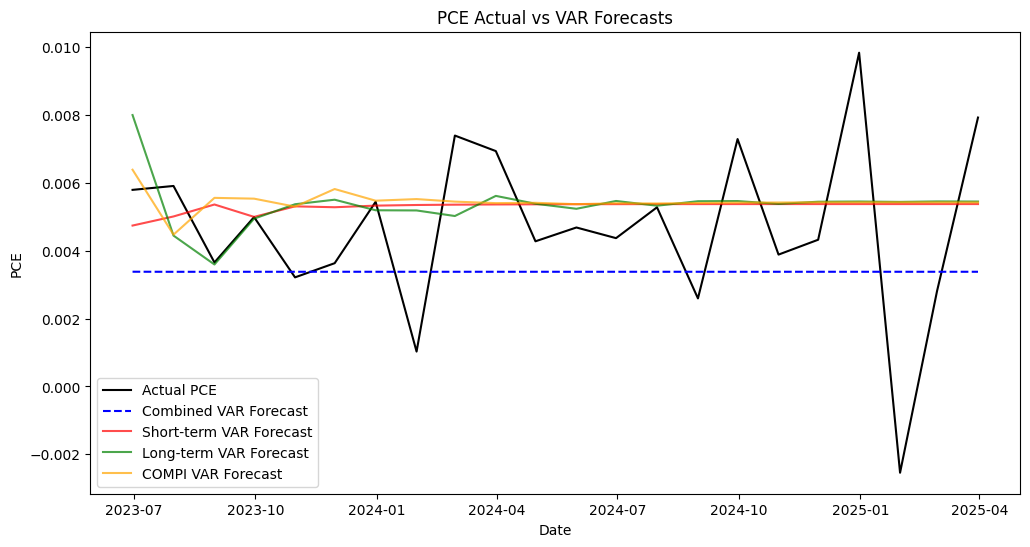

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Actual PCE', color='black')
plt.plot(y_test.index, final_forecast, label='Combined VAR Forecast', color='blue', linestyle='--')
plt.plot(y_test.index, test_preds['short'], label='Short-term VAR Forecast', color='red', alpha=0.7)
plt.plot(y_test.index, test_preds['long'], label='Long-term VAR Forecast', color='green', alpha=0.7)
plt.plot(y_test.index, test_preds['compi'], label='COMPI VAR Forecast', color='orange', alpha=0.7)

plt.title('PCE Actual vs VAR Forecasts')
plt.xlabel('Date')
plt.ylabel('PCE')
plt.legend()
plt.show()


In [33]:
from statsmodels.tsa.api import VAR

model = VAR(df_var)
lag_selection = model.select_order(maxlags=maxlags)
print(lag_selection.summary())

best_lag = lag_selection.selected_orders['aic']  # or 'bic'
print("Best lag by AIC:", best_lag)

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -15.73      -15.68   1.479e-07      -15.71
1      -16.22     -16.03*   9.005e-08     -16.14*
2      -16.25      -15.91   8.770e-08      -16.11
3     -16.25*      -15.77  8.761e-08*      -16.05
4      -16.21      -15.58   9.142e-08      -15.95
5      -16.20      -15.42   9.262e-08      -15.88
-------------------------------------------------
Best lag by AIC: 3


/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [34]:
# var_model = model.fit(best_lag)

# target = 'PCE'
# significant_vars = ['PCE']  # always keep PCE in model

# for var in [c for c in df_var.columns if c != target]:
#     test = var_model.test_causality(target, var, kind='f')
#     pval = test.pvalue
#     print(f"{var} → {target}: p-value = {pval:.4f}")
#     if pval < 0.05:
#         significant_vars.append(var)

# print("Variables significantly Granger-causing PCE:", significant_vars)
var_model = model.fit(best_lag)

target = 'PCE'
significant_vars = ['PCE']  # always keep PCE in model

for var in [c for c in df_var.columns if c != target]:
    test = var_model.test_causality(caused=target, causing=var, kind='f')
    pval = test.pvalue
    print(f"{var} → {target}: p-value = {pval:.4f}")
    if pval < 0.05:
        significant_vars.append(var)

print("Variables significantly Granger-causing PCE:", significant_vars)



UNRATE → PCE: p-value = 0.0299
CPI → PCE: p-value = 0.0299
Variables significantly Granger-causing PCE: ['PCE', 'UNRATE', 'CPI']


We prove breakpoints for pen 2 are not needed so we proceed with breakpoints for covid only

In [33]:
df_stationary['break_1']= (df_stationary.index>=bps_pen3[0]).astype(int)
df_stationary['break_2']= (df_stationary.index >= bps_pen3[1]).astype(int)



In [56]:
df_all= pd.read_csv("df_all.csv", index_col=0)

In [57]:
df_all.index= pd.to_datetime(df_all.index)
df_all['break_1']= (df_all.index>=bps_pen3[0]).astype(int)
df_all['break_2']= (df_all.index >= bps_pen3[1]).astype(int)

In [59]:
df_all.to_csv("df_all.csv", index=True)

In [34]:
df_stationary

,UNRATE,PCE,CPI,FEDFUNDS,M2,WAGE_AVG,INDPRO,GDPDEF,CSENT,CRUDE,COMPI,LABOR,break_1,break_2
2006-05-31,-0.1,0.004364,0.600,0.15,0.001013,-0.000993,0.000251,0.000,-8.3,4.260482,0.009088,0.0,0,0
2006-06-30,0.0,0.003007,0.500,0.05,0.005591,0.004955,0.003362,0.000,5.8,4.261988,0.001808,0.1,0,0
2006-07-31,0.1,0.009052,1.100,0.25,0.006082,0.002962,-0.000653,0.586,-0.2,4.309604,0.004205,-0.1,0,0
2006-08-31,0.0,-0.000171,0.900,0.01,0.004544,0.001477,0.004331,0.000,-2.7,4.291049,0.006573,0.1,0,0
2006-09-30,-0.2,0.003547,-1.000,0.00,0.003934,0.003929,-0.001813,0.000,3.4,4.155722,-0.015002,-0.1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-30,0.1,0.004322,0.885,-0.19,0.004721,0.003657,-0.002581,0.000,1.3,4.247781,0.000514,0.0,1,1
2024-12-31,-0.1,0.009832,1.154,-0.16,0.000807,0.001964,0.010677,0.000,2.2,4.250181,0.000837,0.0,1,1
2025-01-31,-0.1,-0.002543,1.483,-0.15,0.003217,0.004195,-0.001595,1.127,-2.3,4.327339,0.015416,0.1,1,1
2025-02-28,0.1,0.002811,0.689,0.00,0.003402,0.001952,0.009577,0.000,-7.0,4.270161,0.008273,-0.2,1,1


3 Different regimes 

In [38]:
df_precovid=df_stationary.loc[(df_stationary['break_1']==0) & (df_stationary['break_2']==0) ] 
df_covid=df_stationary.loc[(df_stationary['break_1']==1) & (df_stationary['break_2']==0) ] 
df_postcovid=df_stationary.loc[(df_stationary['break_1']==1) & (df_stationary['break_2']==1) ] 
# df_precovid.tail(10)

Hypothesis Testing for diffeerent timeperiods 


In [42]:
from statsmodels.tsa.stattools import grangercausalitytests
predictors = list(df_stationary.columns )

targets=['PCE', 'UNRATE', 'M2']
"""for each target  run granger causality tests with predictors """
max_lag =6
def generate_test_results(max_lag , df, targets, predictors):

    results_list=[]
    for target in targets:
        for predictor in predictors:
            if df[target].nunique() <= 1 or df[predictor].nunique() <= 1:
                print(f"Skipped constant column pair: {target}, {predictor}")
                continue

            if(predictor== target):
                continue

            results= grangercausalitytests(df[[target, predictor]], maxlag=max_lag, verbose=False)
            for lag in range(1, max_lag+1):
                p_val= results[lag][0]['ssr_ftest'][1]
                results_list.append({
                    'target': target,
                    'predictor': predictor,
                    'lag': lag,
                    'p_value': p_val
                })
            
            

    return pd.DataFrame(results_list)


precovid_test_df= generate_test_results(max_lag, df_precovid,targets , predictors) 
# have only max p_value lag i.e for a predictor and target only consider best lag 
precovid_test_df = precovid_test_df[precovid_test_df['p_value'] < 0.05]

precovid_test_df=  (precovid_test_df.sort_values('p_value'))
df_bestpairs_precovid= precovid_test_df.groupby(['target', 'predictor']).apply(lambda g: g.loc[g['p_value'].idxmin()]).reset_index(drop=True)
print(df_bestpairs_precovid.columns)
df_bestpairs_precovid.to_csv("granger_outputs/precovid_significant_factors.csv")


/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since fu

Skipped constant column pair: PCE, break_1
Skipped constant column pair: PCE, break_2
Skipped constant column pair: UNRATE, break_1
Skipped constant column pair: UNRATE, break_2
Skipped constant column pair: M2, break_1
Skipped constant column pair: M2, break_2
Index(['target', 'predictor', 'lag', 'p_value'], dtype='object')


/var/folders/0s/cw7q4t4101d4kfhgpnb3p61h0000gn/T/ipykernel_47494/1864092715.py:39: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_bestpairs_precovid= precovid_test_df.groupby(['target', 'predictor']).apply(lambda g: g.loc[g['p_value'].idxmin()]).reset_index(drop=True)


Covid Era 

In [46]:
test_res_covid=generate_test_results(3, df_covid,targets, predictors)
test_res_covid= test_res_covid.loc[(test_res_covid['p_value']<0.05)]
best_pairs_covid = test_res_covid.groupby(['target', 'predictor']).apply(lambda g:g.loc[ g['p_value'].idxmin()]).reset_index(drop=True)
best_pairs_covid.to_csv('granger_outputs/covid_significant_factors.csv')

Skipped constant column pair: PCE, break_1
Skipped constant column pair: PCE, break_2
Skipped constant column pair: UNRATE, break_1
Skipped constant column pair: UNRATE, break_2
Skipped constant column pair: M2, break_1
Skipped constant column pair: M2, break_2


/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since fu

PostCovid Era

In [48]:
test_res_postcovid=generate_test_results(max_lag, df_postcovid,targets, predictors)
test_res_postcovid= test_res_postcovid.loc[(test_res_postcovid['p_value']<0.05)]
best_pairs_postcovid = test_res_postcovid.groupby(['target', 'predictor']).apply(lambda g:g.loc[ g['p_value'].idxmin()]).reset_index(drop=True)
best_pairs_postcovid.to_csv('granger_outputs/postcovid_significant_factors.csv')

Skipped constant column pair: PCE, break_1
Skipped constant column pair: PCE, break_2
Skipped constant column pair: UNRATE, break_1
Skipped constant column pair: UNRATE, break_2
Skipped constant column pair: M2, break_1
Skipped constant column pair: M2, break_2


/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dsc_env/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since fu

Saving Segments

In [50]:
df_precovid.to_csv("granger_outputs/df_precovid.csv", index=True)
df_covid.to_csv("granger_outputs/df_covid.csv", index=True)
df_postcovid.to_csv("granger_outputs/df_postcovid.csv", index=True)
df_stationary.to_csv("granger_outputs/df_stationary.csv",index=True)